# BIM 2 - Visualización de Ranking 2010-2016
**Fecha de entrega:** 26 de junio  
**Integrantes:** Jean Alejo, Diana Bermeo, Jonathan Calero


## Primera Parte: Análisis Exploratorio de Datos (EDA)
**Objetivo:** Conocer el dataset, entender su estructura y detectar relaciones significativas entre variables numéricas y categóricas.


### *1.Carga de librerías y configuración inicial*

In [92]:
# Importa el módulo 'os' para trabajar con rutas de archivos y operaciones del sistema operativo
import os
# Importa la biblioteca pandas, útil para leer archivos Excel y trabajar con DataFrames en memoria
import pandas as pd
# Importa la clase SparkSession, necesaria para iniciar una sesión de PySpark
from pyspark.sql import SparkSession
# Importa la función 'reduce', que se utiliza para aplicar una función acumulativa a una lista
from functools import reduce
# Importa la clase DataFrame de PySpark para trabajar con tablas distribuidas
from pyspark.sql import DataFrame
import unicodedata  # Permite trabajar con caracteres Unicode, útil para normalizar texto y eliminar acentos o tildes.
import re           # Proporciona funciones de expresiones regulares para buscar y manipular patrones en cadenas de texto.
# Importa el módulo de correlación de Spark MLlib para calcular matrices de correlación
from pyspark.ml.stat import Correlation

# Importa funciones específicas de Spark SQL para trabajar con columnas y operaciones condicionales
from pyspark.sql.functions import col, sum, when

# Instala las bibliotecas de visualización (sólo se hace una vez en Colab)
!pip install matplotlib seaborn

# Importa matplotlib para crear gráficos
import matplotlib.pyplot as plt

# Importa seaborn para visualizaciones estadísticas más avanzadas
import seaborn as sns

# Importa tipos de datos de Spark SQL (para verificar y trabajar con tipos de columnas)
from pyspark.sql.types import StringType, NumericType

# Importa la función promedio para cálculos estadísticos en columnas numéricas
from pyspark.sql.functions import avg

# Importa numpy para cálculos numéricos y manipulación de arreglos
import numpy as np

# Importa el transformador StringIndexer para convertir columnas categóricas a numéricas
from pyspark.ml.feature import StringIndexer

# Importa codificador OneHotEncoder y ensamblador de vectores (VectorAssembler)
# para preparar los datos antes de entrenar un modelo
from pyspark.ml.feature import OneHotEncoder, VectorAssembler

# Importa Pipeline, que permite encadenar varias transformaciones y modelos en una secuencia lógica
from pyspark.ml import Pipeline

### *2.Inicia una sesión de Spark*

In [93]:
# Si ya existe una, la reutiliza; si no, crea una nueva.
spark = SparkSession.builder.appName("RankingCompanias").getOrCreate()

### *3.Función para Normalizar y Estandarizar Nombres de Columnas*

Garantizar que los nombres de las columnas sean consistentes, limpias y uniformes para facilitar su manejo posterior en el análisis y evitar errores por caracteres especiales, tildes o formatos inconsistentes (como años pegados al final).

In [94]:
# Función para limpiar y estandarizar los nombres de columnas
def limpiar_col_utf8(col):
    # Elimina años pegados al final de la cadena (ej. "actividad2010" -> "actividad")
    col = re.sub(r'\s*(2010|2011|2012|2013|2014|2015|2016)$', '', col)
    # Normaliza caracteres Unicode y elimina tildes (acentos)
    col = unicodedata.normalize('NFKD', col)
    col = col.encode('ASCII', 'ignore').decode('utf-8')
    # Elimina caracteres que no sean alfanuméricos o espacios, excepto el guion bajo
    col = re.sub(r'[^\w\s]', '', col)
    # Convierte el texto a minúsculas
    col = col.lower()
    # Reemplaza espacios por guiones bajos para formar nombres válidos
    col = col.replace(' ', '_')
    # Cambia nombres equivalentes a "año" por "year" para estandarizar
    if col == 'ano' or col == 'a_o' or col == 'ano_':
        col = 'year'
    return col

### *4.Bloque de Carga, Limpieza y Unión de Datos por Año*

Este bloque automatiza la carga y procesamiento de múltiples archivos Excel, cada uno correspondiente a un año específico (2010-2016). Se realiza una limpieza previa que incluye la eliminación de columnas innecesarias y la estandarización de nombres para asegurar la uniformidad. Finalmente, convierte los datos a DataFrames de Spark y los une en un único DataFrame consolidado para facilitar su análisis conjunto y eficiente, aprovechando la capacidad de procesamiento distribuido de Spark.

In [95]:
# Ruta base donde están ubicados los archivos Excel
ruta_base = "/content"

# Rango de años para los archivos que vamos a procesar (2010 a 2016 inclusive)
anios = range(2010, 2017)

# Lista para almacenar los DataFrames de Spark que se irán creando por cada año
df_spark_list = []

# Bucle para cargar, limpiar y convertir cada archivo Excel por año
for anio in anios:
    # Construye la ruta completa del archivo Excel
    archivo = os.path.join(ruta_base, f"ranking_{anio}.xlsx")

    # Lee el archivo Excel con pandas, saltándose la primera fila (que puede ser una fecha o metadato)
    df_pandas = pd.read_excel(archivo, engine='openpyxl', skiprows=1)

    # Elimina la tercera y cuarta columna (índices 2 y 3), que no se desean incluir
    df_pandas = df_pandas.drop(df_pandas.columns[[2, 3]], axis=1)

    # Limpia y estandariza los nombres de columnas usando la función creada antes
    df_pandas.columns = [limpiar_col_utf8(c) for c in df_pandas.columns]

    # Elimina columnas duplicadas para evitar errores al unir DataFrames
    df_pandas = df_pandas.loc[:, ~df_pandas.columns.duplicated()]

    # Convierte el DataFrame de pandas a un DataFrame de Spark para procesamiento distribuido
    df_spark = spark.createDataFrame(df_pandas)

    # Agrega el DataFrame de Spark a la lista para luego unir todos
    df_spark_list.append(df_spark)

# Une todos los DataFrames de Spark en uno solo, combinando por nombres de columnas
df_total = reduce(DataFrame.unionByName, df_spark_list)

**Conclusión de unión del los dataset:** En este proceso, se realiza una unión de varios archivos Excel correspondientes a diferentes años (del 2010 al 2016) con el objetivo de consolidar la información en un solo DataFrame.  La unión se lleva a cabo utilizando unionByName, lo que permite integrar los datasets manteniendo la correspondencia entre columnas con el mismo nombre. Esta metodología permite construir una vista integral de los datos a lo largo del tiempo, facilitando análisis comparativos y evolutivos entre los diferentes años.

### *5. Información general del DataFrame Resultante*

Este bloque permite inspeccionar rápidamente la estructura y el contenido del DataFrame consolidado

In [96]:
# Imprimir los nombres de las columnas en lista
print("\n=== Nombres de las columnas ===")
print(df_total.columns)


=== Nombres de las columnas ===
['posicin', 'ao', 'expediente', 'nombre', 'tipo_compaa', 'actividad_econmica', 'regin', 'provincia', 'ciudad', 'tamao', 'sector', 'cant_empleados', 'activio', 'patrimonio', 'ingreso_por_ventas', 'utilidad_antes_del_impuesto', 'utilidad_del_ejercicio', 'utilidad_neta', 'ir_causado', 'ingreso_total']


La obtención de las columnas permitió identificar errores ortográficos en los nombres, por lo que se aplicó este bloque de código para corregirlos y asegurar la consistencia y claridad de los datos:

In [97]:
df_total = df_total.withColumnRenamed("posicin", "posicion") \
                   .withColumnRenamed("ao", "year") \
                   .withColumnRenamed("tipo_compaa", "tipo_compania") \
                   .withColumnRenamed("actividad_econmica", "actividad_economica") \
                   .withColumnRenamed("regin", "region") \
                   .withColumnRenamed("tamao", "tamano")

# **Análisis Exploratorio de Datos (EDA)**

### Mostrar el esquema del DataFrame (nombres de columnas y tipos)

In [98]:
print("=== Esquema del DataFrame ===")
df_total.printSchema()
print(f"Total de registros: {df_total.count()}")

=== Esquema del DataFrame ===
root
 |-- posicion: long (nullable = true)
 |-- year: long (nullable = true)
 |-- expediente: long (nullable = true)
 |-- nombre: string (nullable = true)
 |-- tipo_compania: string (nullable = true)
 |-- actividad_economica: string (nullable = true)
 |-- region: string (nullable = true)
 |-- provincia: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- tamano: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- cant_empleados: long (nullable = true)
 |-- activio: double (nullable = true)
 |-- patrimonio: double (nullable = true)
 |-- ingreso_por_ventas: double (nullable = true)
 |-- utilidad_antes_del_impuesto: double (nullable = true)
 |-- utilidad_del_ejercicio: double (nullable = true)
 |-- utilidad_neta: double (nullable = true)
 |-- ir_causado: double (nullable = true)
 |-- ingreso_total: double (nullable = true)

Total de registros: 387045


**Conteo del numero de filas y columnas**

In [99]:
# Número total de filas y columnas
num_filas = df_total.count()
num_columnas = len(df_total.columns)
print(f"El dataset contiene {num_filas} filas y {num_columnas} columnas.")

El dataset contiene 387045 filas y 20 columnas.


In [100]:
# Ver las primeras filas
df_total.show(5)

+--------+----+----------+--------------------+-------------+--------------------+------+--------------------+--------------------+------+------------------+--------------+--------------+--------------+------------------+---------------------------+----------------------+-------------+-------------+--------------+
|posicion|year|expediente|              nombre|tipo_compania| actividad_economica|region|           provincia|              ciudad|tamano|            sector|cant_empleados|       activio|    patrimonio|ingreso_por_ventas|utilidad_antes_del_impuesto|utilidad_del_ejercicio|utilidad_neta|   ir_causado| ingreso_total|
+--------+----+----------+--------------------+-------------+--------------------+------+--------------------+--------------------+------+------------------+--------------+--------------+--------------+------------------+---------------------------+----------------------+-------------+-------------+--------------+
|       1|2010|       384|CORPORACION FAVOR...|     

 **Descripción estadística general**

In [101]:
df_total.describe().show()

+-------+------------------+------------------+------------------+-------------+--------------------+--------------------+------+--------------------+--------------------+-------+------------------+-----------------+--------------------+-----------------+--------------------+---------------------------+----------------------+--------------------+------------------+--------------------+
|summary|          posicion|              year|        expediente|       nombre|       tipo_compania| actividad_economica|region|           provincia|              ciudad| tamano|            sector|   cant_empleados|             activio|       patrimonio|  ingreso_por_ventas|utilidad_antes_del_impuesto|utilidad_del_ejercicio|       utilidad_neta|        ir_causado|       ingreso_total|
+-------+------------------+------------------+------------------+-------------+--------------------+--------------------+------+--------------------+--------------------+-------+------------------+-----------------+------

**Análisis de variables categóricas (frecuencias)**

In [102]:
df_total.groupBy("sector").count().show()
df_total.groupBy("region").count().show()
df_total.groupBy("tipo_compania").count().show()
df_total.groupBy("provincia").count().show()
df_total.groupBy("actividad_economica").count().show()
df_total.groupBy("tamano").count().show()

+------------------+------+
|            sector| count|
+------------------+------+
|MERCADO DE VALORES|  2659|
|        SOCIETARIO|384386|
+------------------+------+

+---------+------+
|   region| count|
+---------+------+
|GALAPAGOS|  1955|
|  ORIENTE|  9072|
|   SIERRA|166398|
|    COSTA|209620|
+---------+------+

+--------------------+------+
|       tipo_compania| count|
+--------------------+------+
|      ECONOMÍA MIXTA|   181|
|ANÓNIMA  EN PREDI...|    76|
|RESPONSABILIDAD L...|110572|
|SUCURSAL  EXTRANJERA|  3270|
|ASOCIACIÓN O CONS...|   225|
|SOCIEDAD POR ACCI...|  1470|
|ANÓNIMA MULTINACI...|    55|
|             ANÓNIMA|271194|
|COMANDITA POR ACC...|     2|
+--------------------+------+

+--------------------+------+
|           provincia| count|
+--------------------+------+
|TUNGURAHUA       ...|  6494|
|PASTAZA          ...|   813|
|GALAPAGOS        ...|  1955|
|IMBABURA         ...|  3886|
|MANABI           ...| 15331|
|ORELLANA         ...|  1865|
|PICHINCHA       

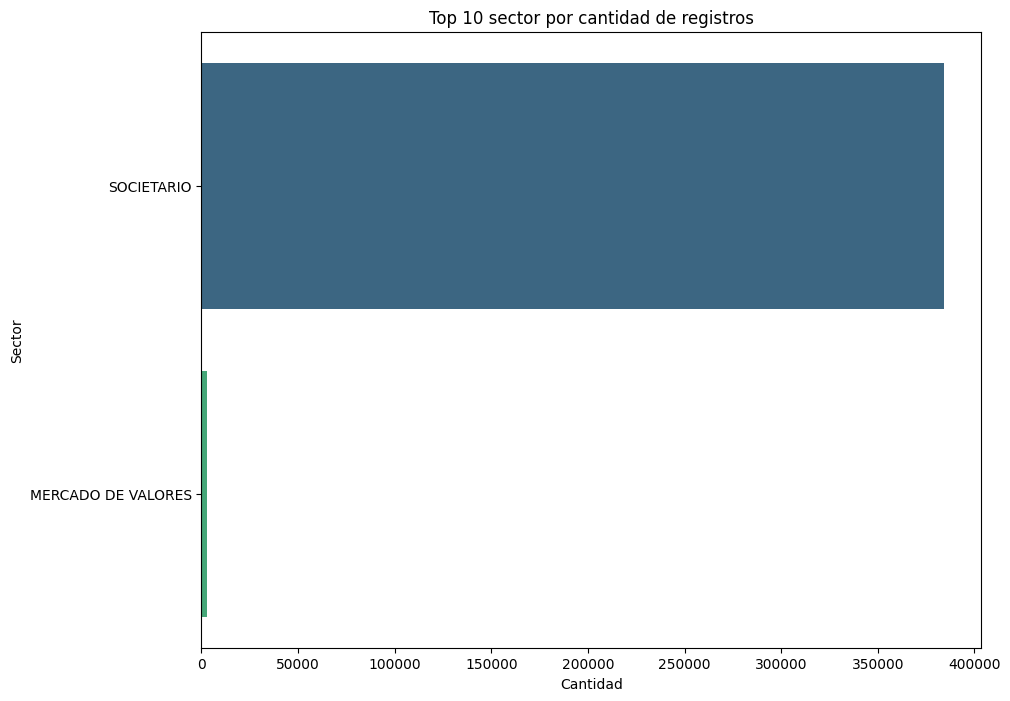

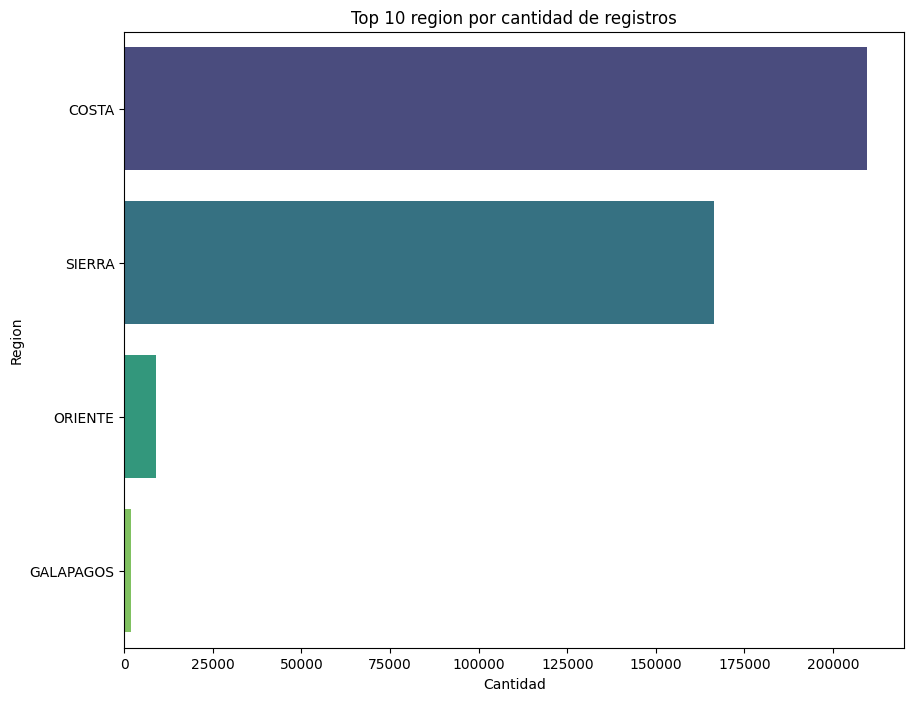

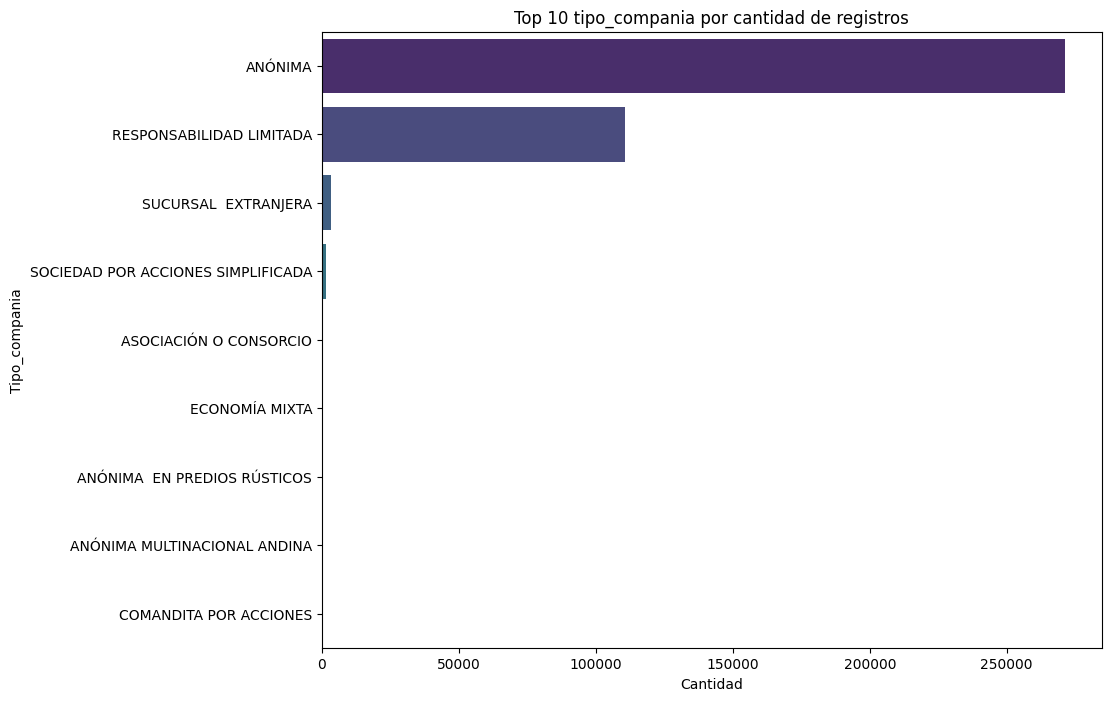

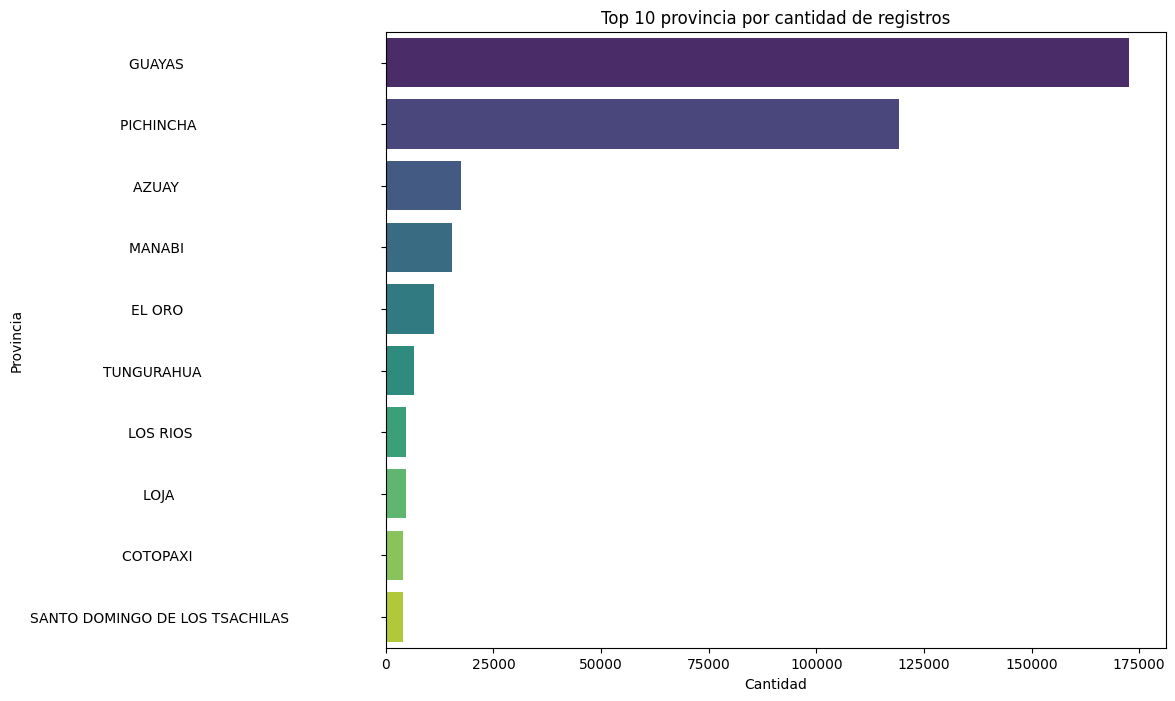

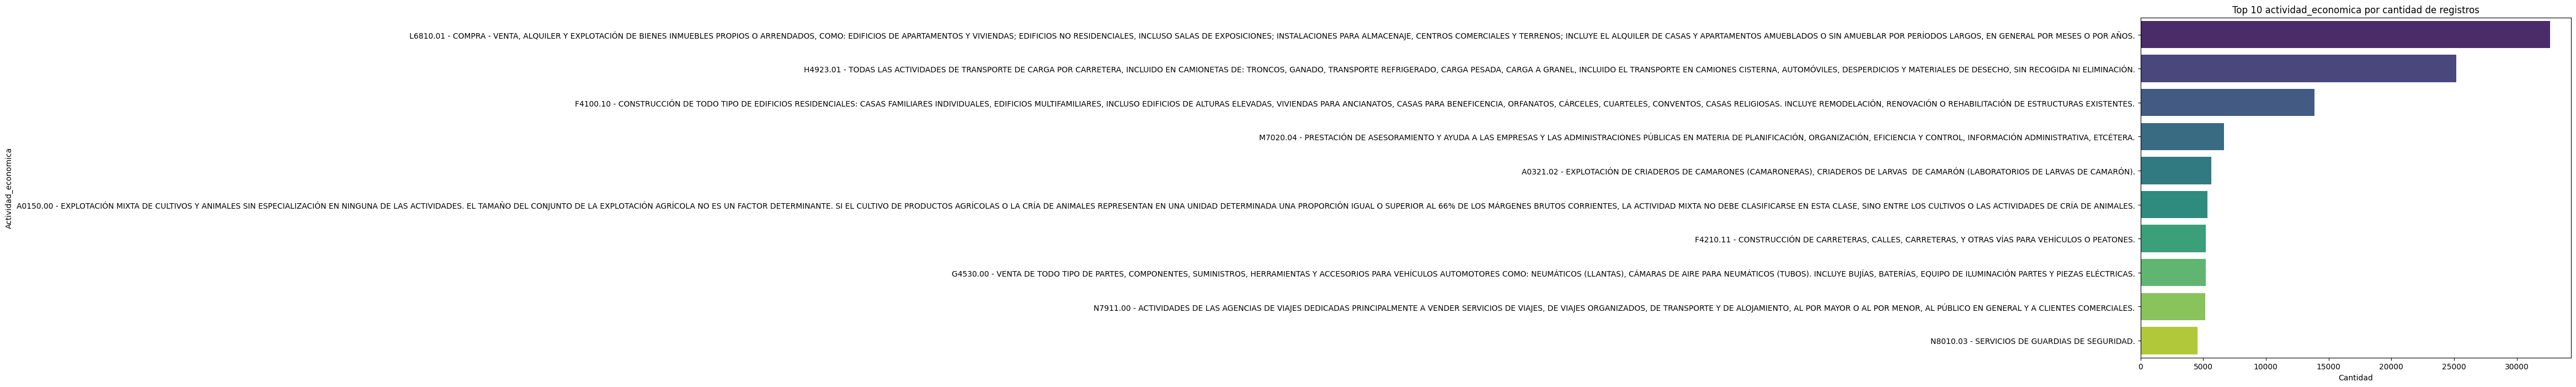

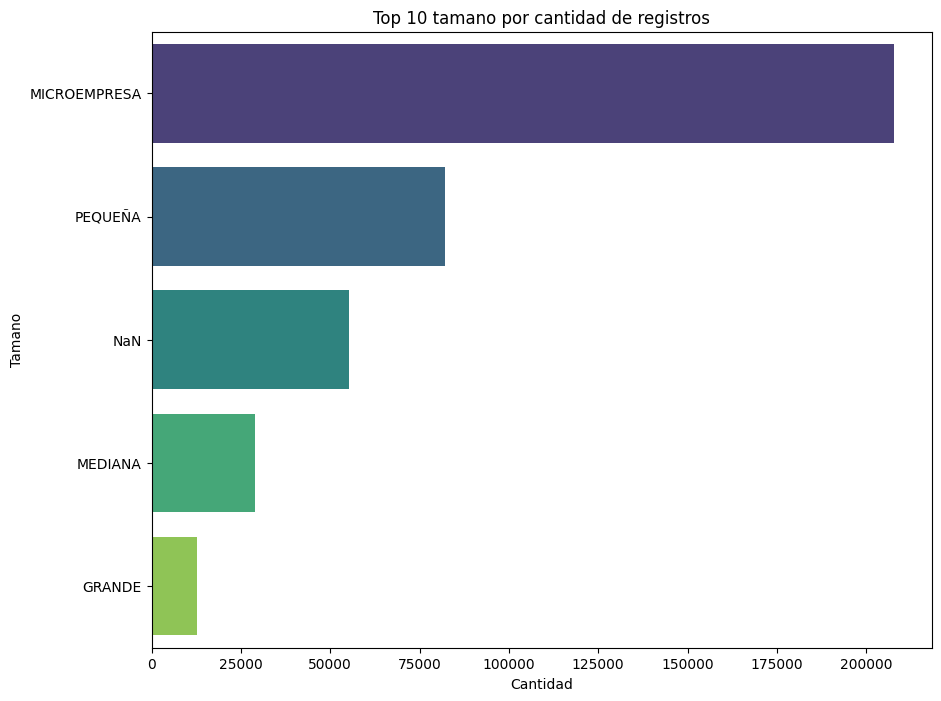

In [103]:
# Función para crear gráfico de barras desde una agrupación PySpark
def plot_group_count(df, columna, top_n=10):
    df_group = df.groupBy(columna).count().orderBy("count", ascending=False).limit(top_n)
    pd_df = df_group.toPandas()

    plt.figure(figsize=(12,8))
    sns.barplot(data=pd_df, x="count", y=columna, hue=columna, palette="viridis", dodge=False, legend=False)
    plt.title(f"Top {top_n} {columna} por cantidad de registros")
    plt.xlabel("Cantidad")
    plt.ylabel(columna.capitalize())
    plt.subplots_adjust(left=0.3, right=0.95)
    plt.show()

# Usar la función para cada columna
columnas = ["sector", "region", "tipo_compania", "provincia", "actividad_economica", "tamano"]
for col_name in columnas:
    plot_group_count(df_total, col_name)


## Conclusión general
### 1. Distribución por Sector
- La mayoría de los registros pertenecen al sector **SOCIETARIO** con 384,386 entradas, mientras que el sector **MERCADO DE VALORES** tiene 2,659 registros.
- Esto indica que el conjunto de datos está dominado por información societaria, posiblemente referida a empresas y sociedades registradas.

### 2. Distribución por Región
- La mayor cantidad de registros se concentra en la **COSTA** (209,620) y la **SIERRA** (166,398).
- Las regiones de **ORIENTE** y **GALÁPAGOS** presentan menos registros (9,072 y 1,955 respectivamente), reflejando probablemente menor actividad económica o menos empresas registradas en estas zonas.

### 3. Distribución por Tipo de Compañía
- El tipo **ANÓNIMA** domina con 271,194 registros, seguido por **RESPONSABILIDAD LIMITADA** con 110,572 registros.
- Otros tipos, como economía mixta o sucursales extranjeras, tienen cantidades mucho menores, mostrando una diversidad limitada en la forma jurídica predominante.

### 4. Distribución por Provincia
- La provincia con mayor número de registros es **GUAYAS** con 172,545 entradas, seguida por **PICHINCHA** con 119,315.
- Otras provincias tienen cantidades menores, reflejando la concentración económica en estas dos provincias principales.

### 5. Distribución por Actividad Económica
- Se muestran códigos de actividades con sus frecuencias; por ejemplo, el código `C1410.02` tiene 767 registros.
- Esto permite identificar qué sectores económicos específicos tienen más representación en el dataset.

### 6. Distribución por Tamaño de Empresa
- La mayoría de las empresas son **microempresas** (207,889), seguido por pequeñas (82,243) y medianas (28,910).
- Las empresas grandes son menos frecuentes (12,610) y hay un número considerable de registros con tamaño no especificado (55,393).

La información agrupada y contada por categorías clave como sector, región, tipo de compañía, provincia, actividad económica y tamaño de empresa, permite una visión clara sobre la composición y distribución del conjunto de datos.

**Correlaciones**

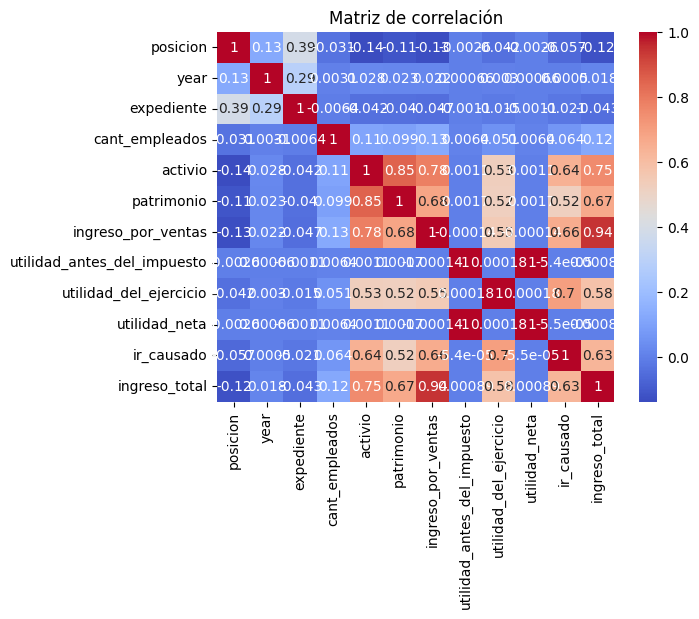

In [104]:
# Visualización de correlación entre variables numéricas
df_pd = df_total.toPandas()
sns.heatmap(df_pd.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()


La matriz de correlación muestra la relación entre diferentes variables financieras y organizativas de empresas. Los valores de correlación varían entre -1 y 1:
Los colores representan:
- Rojo intenso: fuerte correlación positiva.
- Azul intenso: fuerte correlación negativa.
- Blanco o tonos suaves: poca o ninguna correlación.

### **1. Ingreso Total**
- Fuerte correlación con:
  - `ingreso_por_ventas` **(0.94)**
  - `activo` **(0.75)**
  - `patrimonio` **(0.67)**
  - `utilidad_antes_del_impuesto` **(0.80)**
  - `ir_causado` **(0.63)**

**Conclusión**: Las empresas con mayores ventas, activos y patrimonio tienden a tener más ingresos totales.

### **2. Ingreso por Ventas**
- Altamente correlacionado con:
  - `activo` **(0.68)**
  - `utilidad_antes_del_impuesto` **(0.80)**
  - `utilidad_del_ejercicio` **(0.52)**

**Conclusión**: A mayor volumen de ventas, mayor utilidad obtenida.

### **3. Activo**
- Fuerte relación con:
  - `patrimonio` **(0.85)**
  - `ingreso_total`, `ingreso_por_ventas`, `utilidad` (todas entre **0.67 y 0.80**)

**Conclusión**: Un mayor activo implica mayor desempeño financiero.

### **4. Utilidad antes del impuesto y Utilidad neta**
- Correlación casi perfecta entre sí **(≈1.0)**

**Conclusión**: Ambas variables reflejan prácticamente la misma información.

### **5. Posición**
- Correlación negativa leve con:
  - `expediente` **(-0.39)**
  - otras variables financieras (entre **-0.1 y -0.2**)

**Conclusión**: Una mejor posición (menor número) podría reflejar un mejor desempeño, aunque la relación es débil.

### **6. Cantidad de Empleados**
- Baja correlación general, aunque algo positiva con:
  - `activo`, `ingreso_total` (≈ **0.1**)

**Conclusión**: El número de empleados no determina significativamente los resultados financieros.

Por lo tanto las variables más influyentes en el desempeño económico son:
  - `ingreso_por_ventas`
  - `activo`
  - `patrimonio`
  - `utilidad_antes_del_impuesto`
- Estas variables están altamente correlacionadas entre sí.
- Las variables `posición` y `expediente` parecen actuar más como identificadores que como indicadores financieros.


# **Limpieza de datos**

## VALORES DUPLICADOS

In [105]:
total_rows = df_total.count()
unique_rows = df_total.dropDuplicates().count()
duplicadas = total_rows - unique_rows

print(f"Filas totales: {total_rows}")
print(f"Filas únicas: {unique_rows}")
print(f"Filas duplicadas: {duplicadas}")

Filas totales: 387045
Filas únicas: 386459
Filas duplicadas: 586


Durante el proceso de integración por año, se evidenció una duplicación de datos en la columna de posición, debido a que cada dataset comienza desde la primera posición registrada para cada empresa.

### Cast de múltiples columnas numéricas a tipo Long en PySpark

In [106]:
# Lista con los nombres de las columnas que quieres convertir
columnas_a_convertir = ["cant_empleados","activio","patrimonio","ingreso_por_ventas","utilidad_antes_del_impuesto","utilidad_del_ejercicio","utilidad_neta", "ir_causado", "ingreso_total"]

# Convertir las columnas a tipo long
for c in columnas_a_convertir:
    df_total = df_total.withColumn(c, col(c).cast("long"))

# Verificar esquema para confirmar los cambios
df_total.printSchema()

# Mostrar algunos datos para validar
df_total.show()

root
 |-- posicion: long (nullable = true)
 |-- year: long (nullable = true)
 |-- expediente: long (nullable = true)
 |-- nombre: string (nullable = true)
 |-- tipo_compania: string (nullable = true)
 |-- actividad_economica: string (nullable = true)
 |-- region: string (nullable = true)
 |-- provincia: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- tamano: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- cant_empleados: long (nullable = true)
 |-- activio: long (nullable = true)
 |-- patrimonio: long (nullable = true)
 |-- ingreso_por_ventas: long (nullable = true)
 |-- utilidad_antes_del_impuesto: long (nullable = true)
 |-- utilidad_del_ejercicio: long (nullable = true)
 |-- utilidad_neta: long (nullable = true)
 |-- ir_causado: long (nullable = true)
 |-- ingreso_total: long (nullable = true)

+--------+----+----------+--------------------+--------------------+--------------------+------+--------------------+--------------------+------+------

La conversión de las columnas numéricas a un tipo de dato uniforme, como long, mejora la consistencia y precisión en el procesamiento y análisis de datos. Esto facilita las operaciones matemáticas y evita errores derivados de incompatibilidades de tipos, asegurando una manipulación eficiente y confiable del dataset.

##**MOSTRAR LAS FILAS QUE TIENEN ALGÚN VALOR FALTANTE EN CUALQUIER COLUMNA**

**CONTAR CUÁNTOS VALORES FALTANTES HAY POR COLUMNA**

In [107]:


df_total.select([
    sum(
        when(
            (col(c).isNull()) |
            (col(c) == '') |
            (col(c) == None) |
            (col(c) == 'NaN') |
            (col(c) == 'null'), 1
        ).otherwise(0)
    ).alias(c)
    for c in df_total.columns
]).show()


+--------+----+----------+------+-------------+-------------------+------+---------+------+------+------+--------------+-------+----------+------------------+---------------------------+----------------------+-------------+----------+-------------+
|posicion|year|expediente|nombre|tipo_compania|actividad_economica|region|provincia|ciudad|tamano|sector|cant_empleados|activio|patrimonio|ingreso_por_ventas|utilidad_antes_del_impuesto|utilidad_del_ejercicio|utilidad_neta|ir_causado|ingreso_total|
+--------+----+----------+------+-------------+-------------------+------+---------+------+------+------+--------------+-------+----------+------------------+---------------------------+----------------------+-------------+----------+-------------+
|       0|   0|         0|     0|            0|                  0|     0|        0|     0| 55393|     0|             0|      0|         0|                 0|                          0|                     0|            0|         0|            0|
+---

Podemos visualizar si esque existe algun valor null , none o NaN existe en la columna tamaño



**MOSTRAR QUE TIPO DE VALOR FALTANTE EXISTE EN LA COLUMNA tamaño**

In [108]:
df_total.filter(
    (col("tamano").isNull()) |
    (col("tamano") == '') |
    (col("tamano") == 'NaN') |
    (col("tamano") == 'null')
).select("tamano").show()

+------+
|tamano|
+------+
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
|   NaN|
+------+
only showing top 20 rows



Podemos visualizar que el tipo de valor valtante en la columna es de tipo NaN y vamos a proceder con su limpieza, remplazaremos NaN por la palabra **Desconocido**.

In [109]:
df_limpio = df_total.withColumn(
    "tamano",
    when(
        (col("tamano") == 'NaN'),
        "DESCONOCIDO"
    ).otherwise(col("tamano"))
)

Ahora visualizaremos si se ha cambiado correctamente, si el cambio es correcto saldria 0.

In [110]:
df_limpio.select(
    sum(
        when(
            (col("tamano") == 'NaN'), 1
        ).otherwise(0)
    ).alias("tamano")
).show()
df_limpio.show()


+------+
|tamano|
+------+
|     0|
+------+

+--------+----+----------+--------------------+--------------------+--------------------+------+--------------------+--------------------+------+------------------+--------------+---------+----------+------------------+---------------------------+----------------------+-------------+----------+-------------+
|posicion|year|expediente|              nombre|       tipo_compania| actividad_economica|region|           provincia|              ciudad|tamano|            sector|cant_empleados|  activio|patrimonio|ingreso_por_ventas|utilidad_antes_del_impuesto|utilidad_del_ejercicio|utilidad_neta|ir_causado|ingreso_total|
+--------+----+----------+--------------------+--------------------+--------------------+------+--------------------+--------------------+------+------------------+--------------+---------+----------+------------------+---------------------------+----------------------+-------------+----------+-------------+
|       1|2010|       38

##  Identificar tipos de variables

In [111]:
# Variables categóricas
categorical_cols = [f.name for f in df_limpio.schema.fields if isinstance(f.dataType, StringType)]

# Variables numéricas
numeric_cols = [f.name for f in df_limpio.schema.fields if isinstance(f.dataType, NumericType)]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['posicion', 'year', 'expediente', 'cant_empleados', 'activio', 'patrimonio', 'ingreso_por_ventas', 'utilidad_antes_del_impuesto', 'utilidad_del_ejercicio', 'utilidad_neta', 'ir_causado', 'ingreso_total']
Categóricas: ['nombre', 'tipo_compania', 'actividad_economica', 'region', 'provincia', 'ciudad', 'tamano', 'sector']


**Tratamiento de valores atípicos**


**1.Detección de valores atípicos (outliers)**

In [112]:
for col_name in numeric_cols:
    quantiles = df_limpio.approxQuantile(col_name, [0.25, 0.75], 0.05)
    if len(quantiles) == 2:
        Q1, Q3 = quantiles
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df_limpio.filter((col(col_name) < lower) | (col(col_name) > upper))
        print(f"{col_name}: {outliers.count()} outliers")


posicion: 0 outliers
year: 0 outliers
expediente: 19880 outliers
cant_empleados: 68588 outliers
activio: 60596 outliers
patrimonio: 60440 outliers
ingreso_por_ventas: 63048 outliers
utilidad_antes_del_impuesto: 95718 outliers
utilidad_del_ejercicio: 111411 outliers
utilidad_neta: 100967 outliers
ir_causado: 81691 outliers
ingreso_total: 71521 outliers


El análisis de valores atípicos revela que varias variables financieras presentan una alta cantidad de registros extremos, especialmente en indicadores como utilidad del ejercicio, utilidad neta e ingreso por ventas. Esto sugiere una gran variabilidad en los datos económicos del conjunto, posiblemente debido a la naturaleza heterogénea de las empresas analizadas.

**2. Detectar valores negativos**

In [113]:
# Lista de columnas numéricas
columnas_numericas = ["cant_empleados", "activio", "patrimonio", "ingreso_por_ventas",
                      "utilidad_antes_del_impuesto", "utilidad_del_ejercicio",
                      "utilidad_neta", "ir_causado", "ingreso_total"]

# Recorre cada columna y cuenta los valores negativos
for c in columnas_numericas:
    negativos = df_total.filter(col(c) < 0).count()
    print(f"{c}: {negativos} valores negativos")

cant_empleados: 1 valores negativos
activio: 8 valores negativos
patrimonio: 13022 valores negativos
ingreso_por_ventas: 6 valores negativos
utilidad_antes_del_impuesto: 18136 valores negativos
utilidad_del_ejercicio: 41613 valores negativos
utilidad_neta: 24549 valores negativos
ir_causado: 5 valores negativos
ingreso_total: 6 valores negativos


## Tratamiento de estos datos negativos y atípicos

**Paso 1: Winsorización (limitar valores extremos)**

In [114]:
from pyspark.sql.functions import col, when, log1p

def winsorizar_spark(df, columna, lower_pct=0.01, upper_pct=0.99):
    # Obtener los valores de los percentiles
    quantiles = df.approxQuantile(columna, [lower_pct, upper_pct], 0.01)
    lower, upper = quantiles[0], quantiles[1]

    # Reemplazar valores extremos por los límites
    return df.withColumn(columna,
                         when(col(columna) < lower, lower)
                         .when(col(columna) > upper, upper)
                         .otherwise(col(columna)))


**Aplicando a mis columnas que tienen estos datos atipicos:**

In [115]:
columnas_outliers = ['patrimonio', 'ingreso_por_ventas', 'utilidad_antes_del_impuesto',
                     'utilidad_del_ejercicio', 'utilidad_neta', 'ir_causado', 'ingreso_total']

for col_name in columnas_outliers:
    df_total = winsorizar_spark(df_total, col_name)

In [116]:
# Reemplazar negativos por cero para evitar errores con log
for col_name in columnas_outliers:
    df_total = df_total.withColumn(col_name, when(col(col_name) < 0, 0).otherwise(col(col_name)))

# Crear columnas logarítmicas
for col_name in columnas_outliers:
    df_total = df_total.withColumn(f'log_{col_name}', log1p(col(col_name)))
#Visualizar datos
df_total.show()

+--------+----+----------+--------------------+--------------------+--------------------+------+--------------------+--------------------+------+------------------+--------------+---------+------------+------------------+---------------------------+----------------------+-------------+-----------+-------------+------------------+----------------------+-------------------------------+--------------------------+------------------+------------------+------------------+
|posicion|year|expediente|              nombre|       tipo_compania| actividad_economica|region|           provincia|              ciudad|tamano|            sector|cant_empleados|  activio|  patrimonio|ingreso_por_ventas|utilidad_antes_del_impuesto|utilidad_del_ejercicio|utilidad_neta| ir_causado|ingreso_total|    log_patrimonio|log_ingreso_por_ventas|log_utilidad_antes_del_impuesto|log_utilidad_del_ejercicio| log_utilidad_neta|    log_ir_causado| log_ingreso_total|
+--------+----+----------+--------------------+-----------

El análisis reveló la presencia de valores negativos en varias variables financieras del dataset, destacando especialmente en patrimonio, utilidad antes del impuesto, utilidad del ejercicio y utilidad neta. Estos valores negativos pueden estar relacionados con pérdidas económicas o pasivos acumulados por parte de algunas empresas,  lo cual es financieramente válido pero puede ser interpretado como atípico desde una perspectiva estadística.

**Conclusión:** Durante el análisis encontramos valores atípicos significativos en variables como ingresos y utilidades, que podían distorsionar los resultados. Para controlar estos extremos sin perder datos, aplicamos primero la winsorización, una técnica que limita los valores más altos y bajos a ciertos percentiles para reducir su impacto. Luego, para facilitar el análisis y mejorar la estabilidad estadística, reemplazamos los valores negativos por cero y aplicamos una transformación logarítmica, que comprime la escala de los datos y ayuda a que su distribución sea más equilibrada. En conjunto, estas técnicas permitieron mantener la integridad del conjunto de datos y obtener resultados más robustos y confiables.

In [117]:
# Convertir a Pandas
df_total.count()
df_pandas = df_total.toPandas()
# Guardar como CSV
df_pandas.to_csv("df_final.csv", index=False)
# Descargar
from google.colab import files
files.download("df_final.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [118]:
df_total.count()

387045

# APLICAR PCA (reducción de dimensionalidad no supervisado)

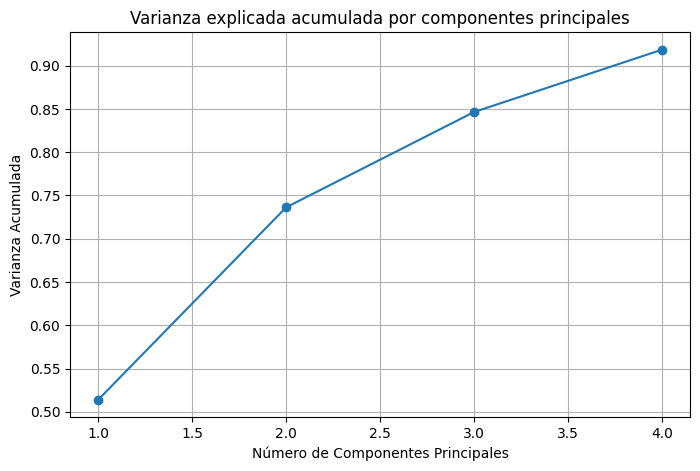

In [119]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Seleccionar solo columnas numéricas
X = df_total.select(columnas_numericas).toPandas().dropna()

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Ver porcentaje de varianza explicada
explained_var = pca.explained_variance_ratio_

# Gráfico de varianza explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var.cumsum(), marker='o')
plt.title('Varianza explicada acumulada por componentes principales')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.show()

La gráfica nos permite deducir que con solo 4 componentes principales se puede explicar aproximadamente 90% de la varianza total de los datos.
A partir del componente 5, la ganancia de información adicional se vuelve marginal (curva se aplana).

# Aplicar Random Forest (Feature Selection real)

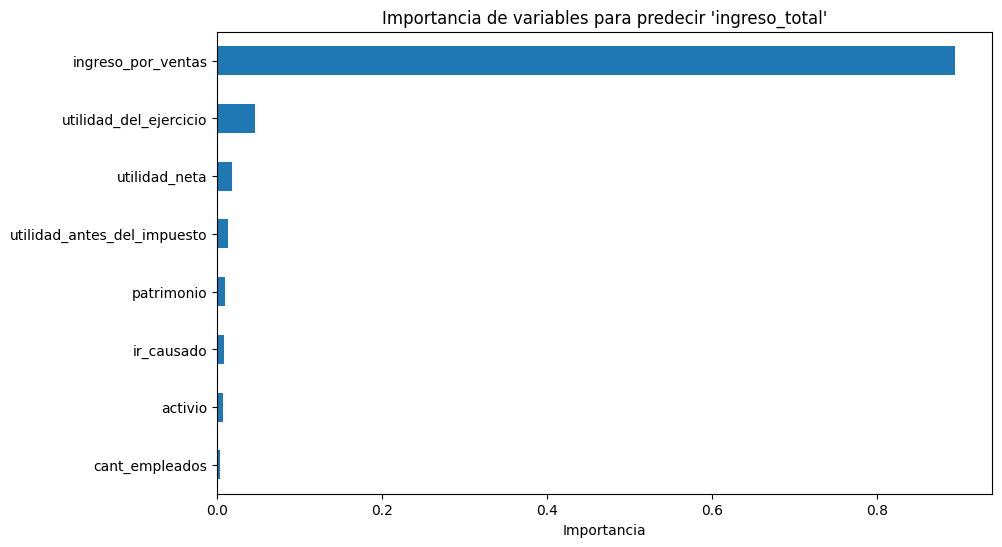

Variables más influyentes según Random Forest:
ingreso_por_ventas             0.895561
utilidad_del_ejercicio         0.046003
utilidad_neta                  0.017221
utilidad_antes_del_impuesto    0.012973
patrimonio                     0.009524
ir_causado                     0.008328
activio                        0.006753
cant_empleados                 0.003636
dtype: float64


In [120]:
from sklearn.ensemble import RandomForestRegressor
# 2. Convertir a pandas y eliminar valores faltantes
df_num = df_total.select(columnas_numericas).toPandas().dropna()

# 3. Separar X e y
X_rf = df_num.drop(columns=["ingreso_total"])
y_rf = df_num["ingreso_total"]

# 4. Entrenar modelo
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_rf, y_rf)

# 5. Obtener importancias
importancias = pd.Series(modelo_rf.feature_importances_, index=X_rf.columns)
importancias_ordenadas = importancias.sort_values(ascending=False)

# 6. Visualizar
plt.figure(figsize=(10, 6))
importancias_ordenadas.plot(kind='barh')
plt.title("Importancia de variables para predecir 'ingreso_total'")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.show()

# 7. Mostrar top variables
print("Variables más influyentes según Random Forest:")
print(importancias_ordenadas)


Los resultados muestran que la variable **`ingreso_por_ventas`** es, con gran diferencia, la más influyente en el modelo, aportando casi un **90%** de la importancia total. Esto indica que el volumen de ventas es el principal determinante de la rentabilidad empresarial, lo cual es coherente con la lógica financiera.  
Otras variables con menor pero significativa relevancia son:
- **`utilidad_del_ejercicio`** (6.0%): representa la ganancia neta después de impuestos.
- **`utilidad_antes_del_impuesto`** (1.3%): muestra cómo varían las ganancias antes de obligaciones fiscales.

Variables como **`patrimonio`**, **`ir_causado`**, **`activio`** y **`cant_empleados`** presentan una importancia mucho menor (<1%), lo que sugiere que tienen una relación más débil o indirecta con la utilidad neta.

# Comparación de modelos: PCA vs. Variables originales

**Escalamos X_rf (variables originales sin ingreso_total).**

In [121]:
scaler = StandardScaler()
X_original_scaled = scaler.fit_transform(X_rf)  # mismas columnas, pero ahora escaladas

**Modelo con variables originales**

In [122]:
from sklearn.metrics import r2_score

modelo_original = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_original.fit(X_original_scaled, y_rf)
pred_original = modelo_original.predict(X_original_scaled)

**Modelo con componentes PCA**

In [124]:
modelo_pca = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_pca.fit(X_pca, y_rf)
pred_pca = modelo_pca.predict(X_pca)

### RESULTADOS

In [125]:
print(f"R² con variables originales: {r2_score(y_rf, pred_original):.4f}")
print(f"R² con componentes PCA:     {r2_score(y_rf, pred_pca):.4f}")

R² con variables originales: 0.9926
R² con componentes PCA:     0.9910


Ambos modelos presentan un alto nivel de precisión, lo que indica que tanto las variables originales como las transformadas mediante PCA contienen información relevante y suficiente para explicar la variación de ingreso_total. Sin embargo, el modelo con variables originales obtuvo un desempeño ligeramente superior,por lo cual podemos recomiendar usar las variables originales si se prioriza interpretabilidad y precisión; mientras que PCA es útil cuando se necesita reducir dimensiones por motivos de eficiencia o sobreajuste.